In [31]:
# Importing libraries & tools
import pandas as pd
import scipy.stats as stats
# use rpy2 to start & connect to R
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [22]:
%%R
install.packages("ggplot2")

R[write to console]: Installing package into 'D:/Documenten/R/win-library/4.1'
(as 'lib' is unspecified)



--- Please select a CRAN mirror for use in this session ---


R[write to console]: trying URL 'https://ftp.belnet.be/mirror/CRAN/bin/windows/contrib/4.1/ggplot2_3.3.6.zip'

R[write to console]: Content type 'application/zip'
R[write to console]:  length 4127372 bytes (3.9 MB)

R[write to console]: downloaded 3.9 MB




package 'ggplot2' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Arthur\AppData\Local\Temp\Rtmp8icmEs\downloaded_packages


In [24]:
%R library("ggplot2")

'ggplot2','tools','stats',...,'datasets','methods','base'


In [2]:
# Use pandas to load data in tabular format
data = pd.read_csv("example.csv")
data

,algorithm,problem,run,#evaluations,fitness
0,a,a,0,0,10
1,a,a,0,110,15
2,a,a,1,0,11
3,a,a,1,120,20
4,b,a,0,0,11
5,b,a,1,0,10
6,b,a,1,10,11
7,A,b,0,0,125
8,A,b,0,40,130
9,A,b,1,0,125


# Data Cleaning

In [3]:
# We have tested *two* algorithms on *two* problems
# - For algorithms
data["algorithm"].unique()

array(['a', 'b', 'A', 'B'], dtype=object)

In [4]:
# - For problems
data["problem"].unique()

array(['a', 'b'], dtype=object)

In [6]:
# Uh oh! algorithm has multiple casings for the same algorithm
# Convert all strings to lowercase
data["algorithm"] = data["algorithm"].str.lower()

In [8]:
# Example: Filtering on a single column
data[data["algorithm"] == "a"]

,algorithm,problem,run,#evaluations,fitness
0,a,a,0,0,10
1,a,a,0,110,15
2,a,a,1,0,11
3,a,a,1,120,20
7,a,b,0,0,125
8,a,b,0,40,130
9,a,b,1,0,125
10,a,b,1,45,130


In [9]:
# Example: Filtering on two columns
data[(data["algorithm"] == "a") & (data["problem"] == "a")]

,algorithm,problem,run,#evaluations,fitness
0,a,a,0,0,10
1,a,a,0,110,15
2,a,a,1,0,11
3,a,a,1,120,20


In [11]:
pd.merge(data, data, on="algorithm")

,algorithm,problem_x,run_x,#evaluations_x,fitness_x,problem_y,run_y,#evaluations_y,fitness_y
0,a,a,0,0,10,a,0,0,10
1,a,a,0,0,10,a,0,110,15
2,a,a,0,0,10,a,1,0,11
3,a,a,0,0,10,a,1,120,20
4,a,a,0,0,10,b,0,0,125
...,...,...,...,...,...,...,...,...,...
140,b,b,1,35,140,b,0,20,130
141,b,b,1,35,140,b,0,30,140
142,b,b,1,35,140,b,1,0,125
143,b,b,1,35,140,b,1,25,130


problem
a     20
b    140
Name: fitness, dtype: int64

# Example: Data Processing

In [14]:
# Filter out updates with a successor
data_filtered = data.sort_values("#evaluations").groupby(["problem", "algorithm", "run"])["fitness"].last()
# data_filtered is still 'grouped' using its index, resetting the index returns it to a normal dataframe.
data_filtered = data_filtered.reset_index()
data_filtered

,problem,algorithm,run,fitness
0,a,a,0,15
1,a,a,1,20
2,a,b,0,11
3,a,b,1,11
4,b,a,0,130
5,b,a,1,130
6,b,b,0,140
7,b,b,1,140


In [19]:
# Gather fitness samples in a list for each configuration
data_per_configuration = data_filtered.groupby(["problem", "algorithm"])["fitness"].apply(list)
data_per_configuration = data_per_configuration.reset_index()
data_per_configuration

,problem,algorithm,fitness
0,a,a,"[15, 20]"
1,a,b,"[11, 11]"
2,b,a,"[130, 130]"
3,b,b,"[140, 140]"


In [27]:
# Pair configurations that have been performed on the same problem
data_cross = pd.merge(data_per_configuration, data_per_configuration, on="problem")
# excluding configurations with the same algorithm twice.
data_cross = data_cross[data_cross["algorithm_x"] != data_cross["algorithm_y"]]
data_cross

,problem,algorithm_x,fitness_x,algorithm_y,fitness_y
1,a,a,"[15, 20]",b,"[11, 11]"
2,a,b,"[11, 11]",a,"[15, 20]"
5,b,a,"[130, 130]",b,"[140, 140]"
6,b,b,"[140, 140]",a,"[130, 130]"


In [38]:
# perform statistical test for each row
data_cross["test"] = data_cross.apply(lambda r: stats.mannwhitneyu(r["fitness_x"], r["fitness_y"]), axis=1)
data_cross

,problem,algorithm_x,fitness_x,algorithm_y,fitness_y,test
1,a,a,"[15, 20]",b,"[11, 11]","(4.0, 0.22067136191984682)"
2,a,b,"[11, 11]",a,"[15, 20]","(0.0, 0.22067136191984682)"
5,b,a,"[130, 130]",b,"[140, 140]","(0.0, 0.1939308522824107)"
6,b,b,"[140, 140]",a,"[130, 130]","(4.0, 0.1939308522824107)"


# Plotting

## In Python

In [41]:
import matplotlib.pyplot as plt

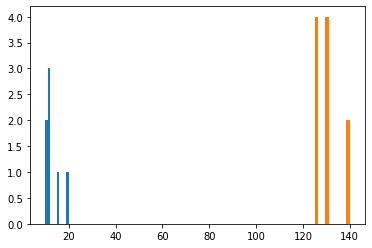

In [43]:
# Via matplotlib
for problem in data["problem"].unique():
    plt.hist(data[data["problem"] == problem]["fitness"])

problem
a    AxesSubplot(0.125,0.125;0.775x0.755)
b    AxesSubplot(0.125,0.125;0.775x0.755)
Name: fitness, dtype: object

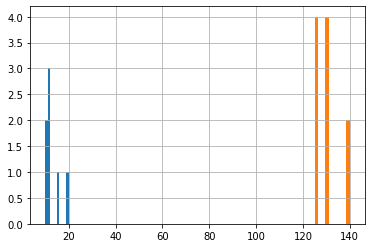

In [40]:
# Via pandas
data.groupby("problem")["fitness"].hist()

In [44]:
import seaborn as sns

<AxesSubplot:xlabel='fitness', ylabel='Count'>

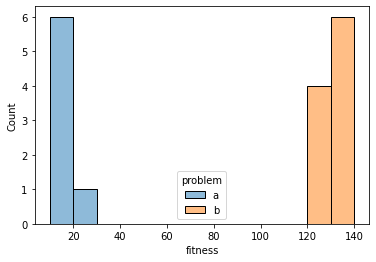

In [47]:
sns.histplot(data=data, x="fitness", hue="problem", binwidth=10)

R[write to console]: `stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



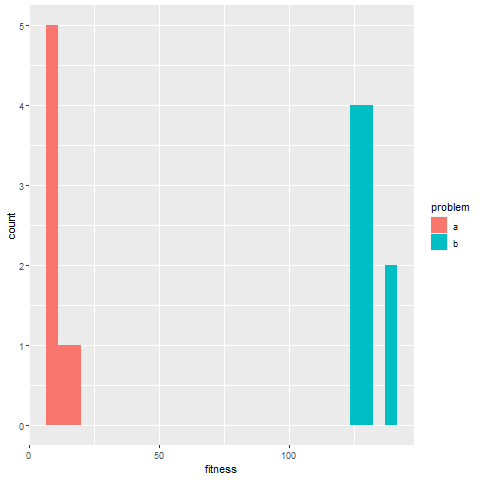

In [57]:
%%R -i data
ggplot(data, aes(x=`fitness`, fill=`problem`)) + geom_histogram()